<a href="https://colab.research.google.com/github/manz01/neo/blob/main/neo_data_analyis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="SQL" src="https://pluspng.com/img-png/nasa-logo-png-file-nasa-logo-svg-1237.png" height="50px"/>


# NEO Earth Close Approaches
Manzar Ahmed


In [ ]:
import subprocess

# Upgrade pip silently
subprocess.run(
    ["pip", "install", "--upgrade", "pip"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

# Install duckdb silently
subprocess.run(
    ["pip", "install", "duckdb", "tabulate", "ace_tools"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

CompletedProcess(args=['pip', 'install', 'duckdb', 'tabulate', 'ace_tools'], returncode=0)

In [ ]:
import requests
import duckdb
import pandas as pd

url = "https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY"
response = requests.get(url)
data = response.json()

neo_by_date = data["near_earth_objects"]
flattened_neos = []

for date_str, neos in neo_by_date.items():
    for neo in neos:
        neo["approach_date"] = date_str
        flattened_neos.append(neo)


df_neos = pd.DataFrame(flattened_neos)

# Process in-memory DuckDb and flatten the json data
conn = duckdb.connect(database=':memory:', read_only=False)

conn.register("df_neos", df_neos)

# Create table from flattened JSON

conn.execute(f"""
    CREATE OR REPLACE TABLE t_raw_neos AS
    SELECT * FROM df_neos
    """)

conn.execute("""
    CREATE OR REPLACE TABLE t_stg_neos AS
    SELECT
        id,
        neo_reference_id,
        name AS neo_name,
        nasa_jpl_url,
        absolute_magnitude_h,
        is_potentially_hazardous_asteroid,
        is_sentry_object
    FROM t_raw_neos;
    """)

conn.execute("""
    CREATE OR REPLACE TABLE t_stg_links AS
    SELECT
        t_raw_neos.id,
        links.self AS self_url
    FROM t_raw_neos;
    """)

conn.execute("""
    CREATE OR REPLACE TABLE t_stg_estimated_diameter AS
    SELECT
        t_raw_neos.id,
        estimated_diameter.kilometers.estimated_diameter_min AS est_dia_km_min,
        estimated_diameter.kilometers.estimated_diameter_max AS est_dia_km_max,
        estimated_diameter.meters.estimated_diameter_min AS est_dia_m_min,
        estimated_diameter.meters.estimated_diameter_max AS est_dia_m_max,
        estimated_diameter.miles.estimated_diameter_min AS est_dia_miles_min,
        estimated_diameter.miles.estimated_diameter_max AS est_dia_miles_max,
        estimated_diameter.feet.estimated_diameter_min AS est_dia_ft_min,
        estimated_diameter.feet.estimated_diameter_max AS est_dia_ft_max
    FROM t_raw_neos;
    """)

conn.execute("""
    CREATE OR REPLACE TABLE t_stg_close_approach_data AS
    SELECT
        t_raw_neos.id,
        ROW_NUMBER() OVER (
            PARTITION BY t_raw_neos.neo_reference_id
            ORDER BY cad.close_approach_date.epoch_date_close_approach
        ) AS close_approach_id,
        cad.close_approach_date.close_approach_date:: date AS close_approach_date,
        cad.close_approach_date.close_approach_date_full,
        cad.close_approach_date.epoch_date_close_approach,
        cad.close_approach_date.relative_velocity.kilometers_per_second,
        cad.close_approach_date.relative_velocity.kilometers_per_hour,
        cad.close_approach_date.relative_velocity.miles_per_hour,
        cad.close_approach_date.miss_distance.astronomical,
        cad.close_approach_date.miss_distance.lunar,
        cad.close_approach_date.miss_distance.kilometers,
        cad.close_approach_date.miss_distance.miles,
        cad.close_approach_date.orbiting_body
    FROM
        t_raw_neos
    CROSS JOIN UNNEST(t_raw_neos.close_approach_data) AS cad (
        close_approach_date,
        close_approach_date_full,
        epoch_date_close_approach,
        relative_velocity,
        miss_distance,
        orbiting_body
    );
    """)

# Join all the data into a flattened table t_det_neos
conn.execute("""
    CREATE OR REPLACE TABLE t_det_neos AS
    WITH NEO_BASE AS (
        SELECT *
        FROM t_stg_neos
        NATURAL JOIN t_stg_links
        NATURAL JOIN t_stg_close_approach_data
    )
        SELECT *
        FROM NEO_BASE
        WHERE
          orbiting_body = 'Earth'
        ORDER BY id, close_approach_id;
    """)

df_neo_clean = conn.execute("SELECT * FROM t_det_neos WHERE orbiting_body = 'Earth' ").fetchdf()

#print(df_neo_clean)
from tabulate import tabulate
print(tabulate(df_neo_clean, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════╤════════════════════╤════════════════════╤═════════════════════════════════════════════════════════════════╤════════════════════════╤═════════════════════════════════════╤════════════════════╤═══════════════════════════════════════════════════════════════╤═════════════════════╤═══════════════════════╤════════════════════════════╤═════════════════════════════╤═════════════════════════╤═══════════════════════╤══════════════════╤════════════════╤══════════╤══════════════╤═════════════╤═════════════════╕
│    │       id │   neo_reference_id │ neo_name           │ nasa_jpl_url                                                    │   absolute_magnitude_h │ is_potentially_hazardous_asteroid   │ is_sentry_object   │ self_url                                                      │   close_approach_id │ close_approach_date   │ close_approach_date_full   │   epoch_date_close_approach │   kilometers_per_second │   kilometers_per_hour │   miles_per_hour │   astronomical │    lunar │  

# Saving a Pandas DataFrame to a Databricks SQL Table
This script demonstrates how to convert a Pandas DataFrame into a Spark DataFrame and then save it as a Delta table in Databricks.

>NOTE: The databricks community edition kept timing out so I am using Google Colab instead. However the code below shows the step to save the data to databricks.

```python
import pandas as pd
from pyspark.sql import SparkSession

"""
Inserts the results to Databricks SQL tables storing:
• All near earth objects
• All instances of a close approach
"""

# Start or get Spark session
spark = SparkSession.builder.getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df_neo_clean)

# Define table name
table_name = "default.t_neo_data"

# Drop table if it exists
spark.sql(f"DROP TABLE IF EXISTS {table_name}")

# Save to Databricks SQL table
spark_df.write.format("delta").mode("overwrite").saveAsTable(table_name)
```

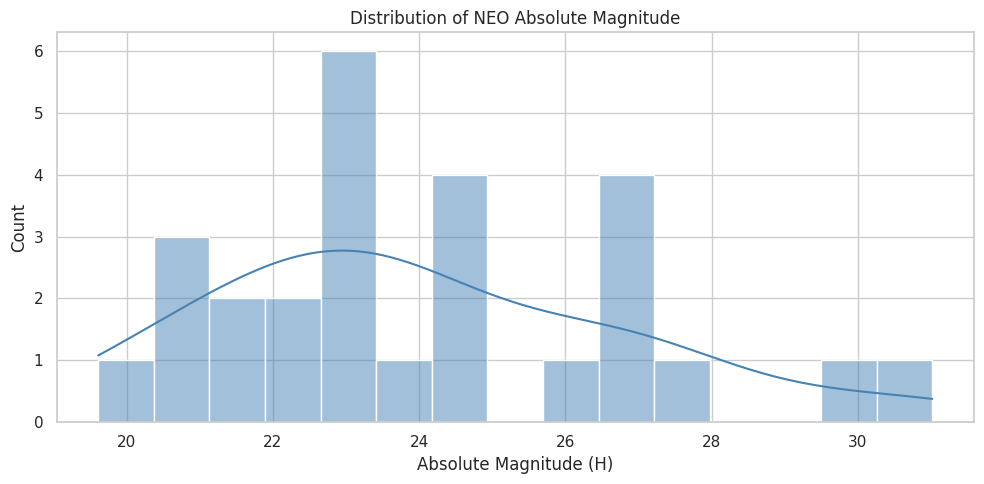

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Placeholder for the final DataFrame, assuming it was already loaded as `df`
# We will simulate its presence here by defining an empty frame for structure (to avoid error)
df = df_neo_clean

# Convert data types for visualization
df["absolute_magnitude_h"] = pd.to_numeric(df["absolute_magnitude_h"], errors='coerce')
df["kilometers_per_hour"] = pd.to_numeric(df["kilometers_per_hour"], errors='coerce')
df["astronomical"] = pd.to_numeric(df["astronomical"], errors='coerce')
df["epoch_date_close_approach"] = pd.to_datetime(df["epoch_date_close_approach"], unit="ms", errors='coerce')
df["is_potentially_hazardous_asteroid"] = df["is_potentially_hazardous_asteroid"].astype(bool)

# Plot 1: Absolute Magnitude Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["absolute_magnitude_h"], bins=15, kde=True, color='steelblue')
plt.title("Distribution of NEO Absolute Magnitude")
plt.xlabel("Absolute Magnitude (H)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

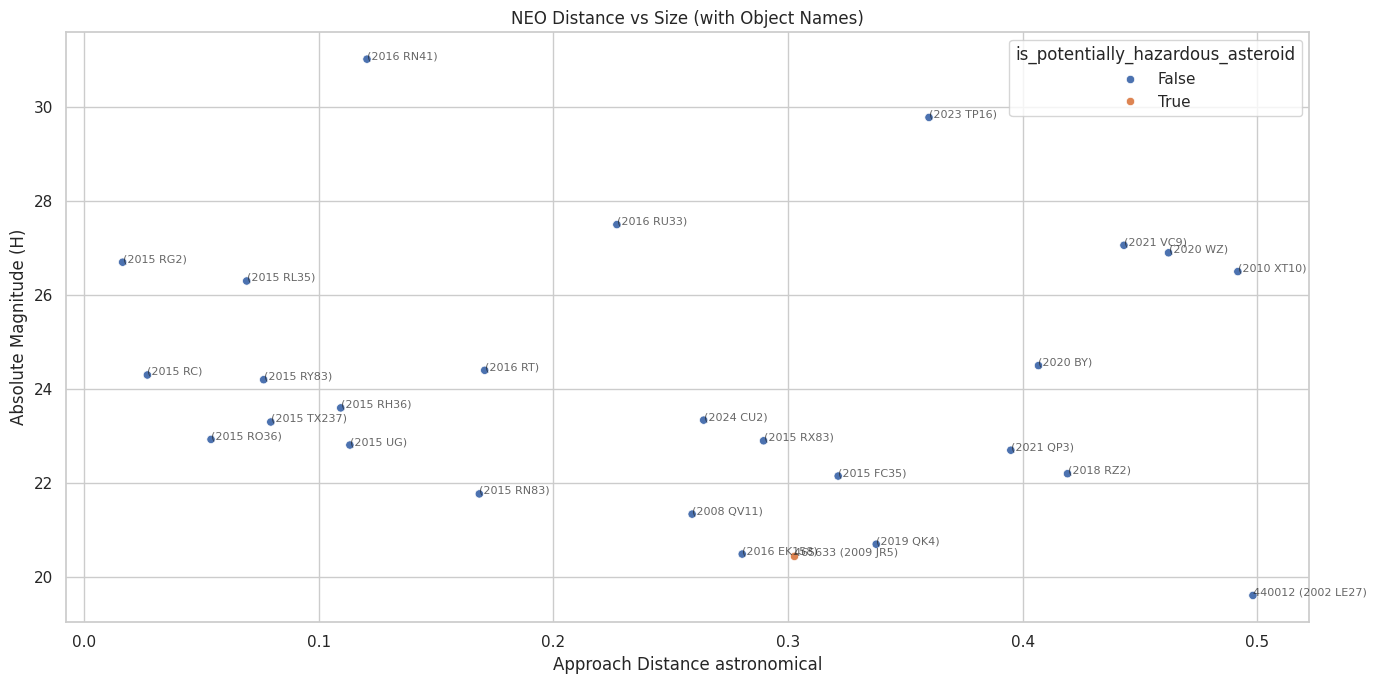

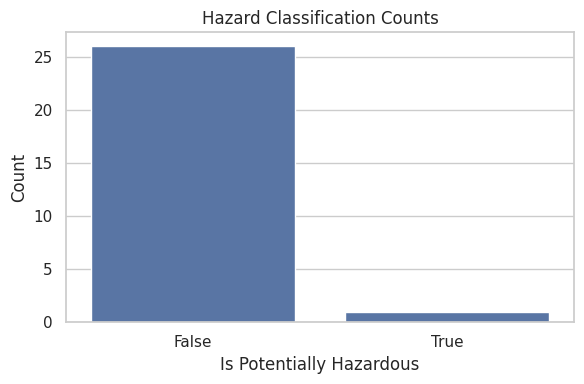

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Create directory for saving plots if it doesn't exist
if not os.path.exists("/mnt/data"):
    os.makedirs("/mnt/data")

# Ensure df is available (assuming it's loaded in previous cells)
df = df_neo_clean

# Ensure datetime is parsed with timezone
df['close_approach_date'] = pd.to_datetime(df['close_approach_date'], utc=True)

# Filter within ±25 years from today
today = pd.Timestamp.today(tz="UTC")
past_25y = today - pd.DateOffset(years=25)
future_25y = today + pd.DateOffset(years=25)
df_filtered = df[(df['close_approach_date'] >= past_25y) & (df['close_approach_date'] <= future_25y)]

# Plot: Approach distance vs size
plt.figure(figsize=(14, 7))
plot = sns.scatterplot(
    data=df_filtered,
    x='astronomical',
    y='absolute_magnitude_h',
    hue='is_potentially_hazardous_asteroid'
)

# Add neo_name as annotations
for _, row in df_filtered.iterrows():
    plot.text(
        row['astronomical'],
        row['absolute_magnitude_h'],
        row['neo_name'],
        fontsize=8,
        alpha=0.7
    )

plt.title("NEO Distance vs Size (with Object Names)")
plt.xlabel("Approach Distance astronomical")
plt.ylabel("Absolute Magnitude (H)")
plt.grid(True)
plt.tight_layout()
plt.savefig("/mnt/data/plot3_distance_vs_size_annotated.png")
plt.show() # Display plot 3


# Plot 4: Orbital Period vs Size
# Removed plot 4 due to missing orbital_period data

# Plot 5: Timeline of close approaches
fig_timeline = px.scatter(
    df_filtered,
    x='close_approach_date',
    y='kilometers',
    color='is_potentially_hazardous_asteroid',
    hover_data=['neo_name', 'absolute_magnitude_h', 'kilometers']
)
fig_timeline.update_layout(
    title="NEO Close Approaches Timeline",
    xaxis_title="Date",
    yaxis_title="Distance from Earth (km)",
)
fig_timeline.write_html("/mnt/data/plot5_timeline_close_approaches.html")
fig_timeline.show() # Display plot 5

# Plot 6: Hazardous vs Non-hazardous count
plt.figure(figsize=(6, 4))
sns.countplot(x='is_potentially_hazardous_asteroid', data=df_filtered)
plt.title("Hazard Classification Counts")
plt.xlabel("Is Potentially Hazardous")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/mnt/data/plot6_hazard_counts.png")
plt.show() # Display plot 6



In [69]:
from tabulate import tabulate
import pandas as pd # Import pandas for to_numeric

# Sample individual object profiles - excluding ace_tools
object_profiles = df_filtered.sort_values(by='close_approach_date')[[
    'neo_name', 'absolute_magnitude_h', 'kilometers',
    'kilometers_per_hour', 'close_approach_date', 'is_potentially_hazardous_asteroid'
]].copy() # Create a copy to avoid SettingWithCopyWarning

# Ensure 'kilometers' is numeric before formatting
object_profiles['kilometers'] = pd.to_numeric(object_profiles['kilometers'], errors='coerce')

# Format 'kilometers' to be more readable (as integers with comma separators)
object_profiles['kilometers'] = object_profiles['kilometers'].apply(lambda x: f"{x:,.0f}" if pd.notnull(x) else '')

# Ensure 'kilometers_per_hour' is numeric before formatting
object_profiles['kilometers_per_hour'] = pd.to_numeric(object_profiles['kilometers_per_hour'], errors='coerce')

# Format 'kilometers_per_hour' to be more readable (as integers with comma separators)
object_profiles['kilometers_per_hour'] = object_profiles['kilometers_per_hour'].apply(lambda x: f"{x:,.0f}" if pd.notnull(x) else '')

# Format 'close_approach_date' to show only the date
object_profiles['close_approach_date'] = object_profiles['close_approach_date'].dt.strftime('%Y-%m-%d')

print("NEO Object Profiles:")
#print(object_profiles)

print(tabulate(object_profiles, headers='keys', tablefmt='fancy_grid', showindex=False))

NEO Object Profiles:
╒════════════════════╤════════════════════════╤══════════════╤═══════════════════════╤═══════════════════════╤═════════════════════════════════════╕
│ neo_name           │   absolute_magnitude_h │ kilometers   │ kilometers_per_hour   │ close_approach_date   │ is_potentially_hazardous_asteroid   │
╞════════════════════╪════════════════════════╪══════════════╪═══════════════════════╪═══════════════════════╪═════════════════════════════════════╡
│ 440012 (2002 LE27) │                  19.61 │ 74,525,036   │ 4,187                 │ 2015-09-07            │ False                               │
├────────────────────┼────────────────────────┼──────────────┼───────────────────────┼───────────────────────┼─────────────────────────────────────┤
│ (2020 WZ)          │                  26.9  │ 69,144,637   │ 72,280                │ 2015-09-07            │ False                               │
├────────────────────┼────────────────────────┼──────────────┼───────────────────────